In [1]:
import torch 
import os
import torch.nn as nn
import seaborn
import koreanize_matplotlib
import torch.nn.functional as F
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import build_vocab_from_iterator
from bareunpy import Tagger
from konlpy.tag import Mecab

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# DEVICE = 'cpu'

In [2]:
import string

PUNCTUATION = string.punctuation
PUNCTUATION

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [3]:
ROOT = './csv/'

tables = []
names = os.listdir(ROOT)
for x in names: tables.append(pd.read_csv(ROOT+x, encoding='utf-8'))



In [4]:
###

df = tables[0]
mask = (df['VerifyEmotionTarget'] != '없음') & (df['VerifyEmotionLevel'] != '약함')
df_yesemo = df[mask]
df_onlytextemo = df_yesemo[['Text', 'VerifyEmotionTarget']].dropna().reset_index(drop=True)

In [5]:
df_onlytextemo['VerifyEmotionTarget'].value_counts()

기쁨       208868
놀라움       49109
화남        25863
슬픔        21197
사랑스러움     18870
두려움       11584
Name: VerifyEmotionTarget, dtype: int64

In [6]:
totaldf = []

for idx, table in enumerate(tables):
    df = table
    mask = (df['VerifyEmotionTarget'] != '없음') & (df['VerifyEmotionLevel'] == '강함')
    df_yesemo = df[mask]
    df_onlytextemo = df_yesemo[['Text', 'VerifyEmotionTarget']].dropna().reset_index(drop=True)
    df_onlytextemo['VerifyEmotionTarget'] = df_onlytextemo['VerifyEmotionTarget'].astype('category')
    totaldf.append(df_onlytextemo.copy())


totaldf = pd.concat(totaldf, axis=0)
totaldf.reset_index(drop=True, inplace=True)


In [7]:
totaldf =totaldf[totaldf['Text'].str.len() > 10]

In [8]:
totaldf['VerifyEmotionTarget'].value_counts()


기쁨       35311
놀라움      22378
화남       20702
슬픔       10060
사랑스러움     7122
두려움       5436
Name: VerifyEmotionTarget, dtype: int64

In [9]:
# test split
from sklearn.model_selection import train_test_split

traindf, testdf = train_test_split(totaldf, test_size=0.2, random_state=42, stratify=totaldf['VerifyEmotionTarget'])
# traindf, testdf = train_test_split(testdf, test_size=0.2, random_state=42, stratify=testdf['VerifyEmotionTarget'])


traindf['VerifyEmotionTarget'].value_counts(), testdf['VerifyEmotionTarget'].value_counts()

(기쁨       28249
 놀라움      17902
 화남       16561
 슬픔        8048
 사랑스러움     5698
 두려움       4349
 Name: VerifyEmotionTarget, dtype: int64,
 기쁨       7062
 놀라움      4476
 화남       4141
 슬픔       2012
 사랑스러움    1424
 두려움      1087
 Name: VerifyEmotionTarget, dtype: int64)

In [10]:
# 전지역으로 설정하기
TABLETARGET = totaldf

In [11]:
TABLETARGET.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101009 entries, 0 to 165786
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Text                 101009 non-null  object  
 1   VerifyEmotionTarget  101009 non-null  category
dtypes: category(1), object(1)
memory usage: 1.6+ MB


In [12]:
TABLETARGET.drop_duplicates(inplace=True)

In [13]:
TABLETARGET.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100956 entries, 0 to 165786
Data columns (total 2 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   Text                 100956 non-null  object  
 1   VerifyEmotionTarget  100956 non-null  category
dtypes: category(1), object(1)
memory usage: 1.6+ MB


In [14]:
from transformers import ElectraModel, ElectraTokenizer


tokenmodel = "monologg/koelectra-base-v3-discriminator"


model_token = ElectraModel.from_pretrained(tokenmodel).to(DEVICE)
tokenizer_trans = ElectraTokenizer.from_pretrained(tokenmodel)
tokenizer_trans.convert_tokens_to_ids(['[UNK]', '[SEP]'])
model_token.estimate_tokens

<bound method ModuleUtilsMixin.estimate_tokens of ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(35000, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0-11): 12 x ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [15]:
# zip_tables = list(zip(tables, names))

class TableDataset(Dataset):
    
    def __init__(self, table):
        super().__init__()
        self.table = table
        self.category = self.table['VerifyEmotionTarget']
        self.label = self.category.cat.codes
        self.catlabel = pd.concat([self.category, self.label], axis=1).value_counts()

        # print(type(self.label), type(self.table), self.label.shape, self.table.shape)
        
    def __len__(self):
        number = len(self.table)
        return number
    
    def __getitem__(self, idx):
        # 데이터 로드
        label = self.label.iloc[idx]
        sentence = self.table['Text'].iloc[idx]
        
        return label, sentence
        
# 토큰화 함수
from jamo import h2j, j2hcj
def tokenize(iterator, tokenizer):
    for label, text in iterator:
        yield tokenizer(text)

def tokenize_baerun(iterator, tokenizer):
    for label, text in iterator:
        yield tokenizer.tags('안녕하세요').morphs()

In [16]:

# 데이터셋 정의
gyd_train = TableDataset(traindf)
gyd_test = TableDataset(testdf)


tokenizer_trans.tokenize(gyd_test[0][1])

['맑', '##은', '식', '##혜', '##를', '먹', '##죠', '설', '수도권', '쪽', '##에', '##는']

In [17]:
traindf.shape, gyd_train.__len__(), testdf.shape, testdf.__len__()

((80807, 2), 80807, (20202, 2), 20202)

In [18]:
UNK = '<unk>'
PAD = '<pad>'

# 토큰화 인스턴스 생성 
with open('./hangul_stopword.txt') as f:
    stopwords = f.read().splitlines()

def tokenizer(x):
    result = tokenizer_trans.tokenize(x)
    for idx, word in enumerate(result):
        for char in word:
            if char in PUNCTUATION:
                result[idx] = result[idx].replace(char, '')
                # print('punc_deleted')
        if word in stopwords:
            result.pop(idx)
            # print('stop_deleted',idx)
    return result


API_KEY = 'koba-TXPHP7A-AOWEX4Y-WCTFG3I-RFAISLA'
tokenizer_baerun = Tagger(API_KEY, '127.0.0.1', 5757)


# tokenizer_baerun = tokenizer_baerun.tags('안녕하세요').morphs()
# tokenizer_baerun

In [19]:
import pickle
VOCAFILE = './vocab_multi.pkl'
if not os.path.exists(VOCAFILE):
    # 단어사전 생성하기 
    vocab = build_vocab_from_iterator(tokenize(gyd_train, tokenizer), specials=[UNK, PAD])
    # vocab = build_vocab_from_iterator(tokenize_baerun(gyd_train, tokenizer_baerun), specials=[UNK, PAD])

    # default unk
    vocab.set_default_index(vocab[UNK])
    with open(VOCAFILE, 'wb') as f:
        pickle.dump(vocab, f)
else:
    with open(VOCAFILE, 'rb') as f:
        vocab = pickle.load(f)
    


In [20]:
vocab(['먹', '것'])

[37, 375]

In [21]:
vocab(['먹', '것', '이', '것'])

[37, 375, 4, 375]

In [22]:
def text_pipeline(x):
    return vocab(tokenizer(x))

# def label_pipeline(x):
#     # 데이터셋에서 라벨을 0부터 잡았으므로 그대로 정수 반환
#     return int(x)

def collate_batch(batch):
    labels, text_list, offsets = [], [], [0]
    
    for label, text in batch:
        
        labels.append(label)
        
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        text_list.append(processed_text)
        
        offsets.append(processed_text.size(0))
        
        
    labels = torch.tensor(labels, dtype=torch.int64).to(DEVICE)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0).to(DEVICE)
    text_list = torch.cat(text_list).to(DEVICE)
    
    return labels, text_list, offsets


In [23]:
BATCHSIZE = 10000
WORKERS = -1 if DEVICE == 'cuda' else 64


trainloader = DataLoader(gyd_train, batch_size=BATCHSIZE, collate_fn=collate_batch, shuffle=True)
testloader = DataLoader(gyd_test, batch_size=BATCHSIZE, collate_fn=collate_batch, shuffle=True)


In [24]:
num_Class = len(gyd_train.category.cat.categories)
vocab_size = len(vocab)
embed_dim = 30
hidden_dim = 30



In [25]:
class TextMulti(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_Class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim*2, num_Class)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        output, _hidden = self.rnn(embedded)
        return self.fc(output)

class TextMultiCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_Class):
        super().__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
        self.cnn1 = nn.Conv1d(in_channels=embed_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=1)
        self.cnn2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim * 2, kernel_size=3, padding=1)
        self.cnn3 = nn.Conv1d(in_channels=hidden_dim *2 , out_channels=hidden_dim * 1, kernel_size=3, padding=1)
        self.fc = nn.Linear(hidden_dim, num_Class)
        self.init_weights()
        
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        embedded = embedded.transpose(1,0)
        output = F.relu(self.cnn1(embedded))
        output = self.maxpool(output)
        output = F.relu(self.cnn2(output))
        output = self.maxpool(output)
        output = F.relu(self.cnn3(output))
        output = self.maxpool(output)
        output = output.transpose(1, 0)
        output = F.dropout(output, p=0.5)
        return self.fc(output)



In [26]:
import numpy as np
class CNN_NLP(nn.Module):
    """An 1D Convulational Neural Network for Sentence Classification."""
    def __init__(self,
                 pretrained_embedding=None,
                 freeze_embedding=False,
                 vocab_size=None,
                 embed_dim=300,
                 filter_sizes=[3, 4, 5],
                 num_filters=[100, 100, 100],
                 num_classes=2,
                 dropout=0.5):
        """
        The constructor for CNN_NLP class.

        Args:
            pretrained_embedding (torch.Tensor): Pretrained embeddings with
                shape (vocab_size, embed_dim)
            freeze_embedding (bool): Set to False to fine-tune pretraiend
                vectors. Default: False
            vocab_size (int): Need to be specified when not pretrained word
                embeddings are not used.
            embed_dim (int): Dimension of word vectors. Need to be specified
                when pretrained word embeddings are not used. Default: 300
            filter_sizes (List[int]): List of filter sizes. Default: [3, 4, 5]
            num_filters (List[int]): List of number of filters, has the same
                length as `filter_sizes`. Default: [100, 100, 100]
            n_classes (int): Number of classes. Default: 2
            dropout (float): Dropout rate. Default: 0.5
        """

        super(CNN_NLP, self).__init__()
        # Embedding layer
        if pretrained_embedding is not None:
            self.vocab_size, self.embed_dim = pretrained_embedding.shape
            self.embedding = nn.Embedding.from_pretrained(pretrained_embedding,
                                                          freeze=freeze_embedding)
        else:
            self.embed_dim = embed_dim
            self.embedding = nn.EmbeddingBag(vocab_size, embed_dim)
            
        # Conv Network
        self.conv1d_list = nn.ModuleList([
            nn.Conv1d(in_channels=self.embed_dim,
                      out_channels=num_filters[i],
                      kernel_size=filter_sizes[i])
            for i in range(len(filter_sizes))
        ])
        # Fully-connected layer and Dropout
        self.fc = nn.Linear(np.sum(num_filters), num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input_ids, offsets):
        """Perform a forward pass through the network.

        Args:
            input_ids (torch.Tensor): A tensor of token ids with shape
                (batch_size, max_sent_length)

        Returns:
            logits (torch.Tensor): Output logits with shape (batch_size,
                n_classes)
        """

        # Get embeddings from `input_ids`. Output shape: (b, max_len, embed_dim)
        x_embed = self.embedding(input_ids, offsets).float()

        # Permute `x_embed` to match input shape requirement of `nn.Conv1d`.
        # Output shape: (b, embed_dim, max_len)
        x_reshaped = x_embed.permute(1, 0)

        # Apply CNN and ReLU. Output shape: (b, num_filters[i], L_out)
        x_conv_list = [F.relu(conv1d(x_reshaped)) for conv1d in self.conv1d_list]

        # Max pooling. Output shape: (b, num_filters[i], 1)
        x_pool_list = [F.max_pool1d(x_conv, kernel_size=x_conv.shape[1])
            for x_conv in x_conv_list]
        
        # Concatenate x_pool_list to feed the fully connected layer.
        # Output shape: (b, sum(num_filters))
        x_fc = torch.cat([x_pool.squeeze(dim=0) for x_pool in x_pool_list],
                         dim=0)
        
        # Compute logits. Output shape: (b, n_classes)
        logits = self.fc(self.dropout(x_fc))

        return logits

In [27]:

model = TextMulti(vocab_size, embed_dim, hidden_dim, num_Class).to(DEVICE)
# model = CNN_NLP(vocab_size=vocab_size, embed_dim=embed_dim, num_classes=num_Class)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)




In [28]:
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassF1Score, MultilabelF1Score, MultilabelConfusionMatrix, MultilabelAccuracy
import numpy as np

def train(model, iterator, optimizer, criterion, scheduler):
    model.train()
    lossagg = []
    f1 = MulticlassF1Score(num_Class).to(DEVICE)
    cm = MulticlassConfusionMatrix(num_Class).to(DEVICE)
    
    
    for label, text, offsets in iterator:
        # label = label.unsqueeze(1)

        # label = F.one_hot(label, num_classes=num_Class).float()

        predictions = model(text, offsets)
        # print(predictions.shape, label.shape)
        # print(predictions.shape, label.shape)
        loss = criterion(predictions, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        lossagg.append(loss.item())
        f1(predictions, label)
        cm(predictions, label)
        
            
    print(f"Train F1 score : {f1.compute()}")
    print(f"Train Confusion Matrix : \n{cm.compute()}")

    return f1.compute().cpu().item(), np.mean(lossagg)
    
def evaluate(model, iterator, criterion):
    model.eval()
    lossagg = []
    f1 = MulticlassF1Score(num_Class).to(DEVICE)
    cm = MulticlassConfusionMatrix(num_Class).to(DEVICE)
    
    
    with torch.no_grad():
        for label, text, offsets in iterator:
            # label = label.unsqueeze(1)
            
            # label = F.one_hot(label, num_classes=num_Class).float()

            predictions = model(text, offsets)
            loss = criterion(predictions, label)
            
            lossagg.append(loss.item())
            f1(predictions, label)
            cm(predictions, label)
            
    print(f"Test F1 score : {f1.compute()}")
    print(f"Test Confusion Matrix : \n{cm.compute()}")
    
    return f1.compute().cpu().item(), np.mean(lossagg), cm.compute().cpu().numpy()


### 병목 증상 설명

- 기존 이미지의 경우에는 GPU에서 돌리는 것이 효과적
- 하지만 단어 태깅이 CPU 에서 이루어지므로 자연어 처리에서는 CPU가 더 효과적임


In [29]:
EPOCHES = 300
results = [[], []]
latestcm = None
for epoch in range(EPOCHES):
    print(f"Epoch {epoch+1} 학습 및 평가 결과")
    tresult, trainloss = train(model, trainloader, optimizer, criterion, scheduler)
    evalresult, val_loss, latestcm = evaluate(model, testloader, criterion)
    

    results[0].append(tresult)
    results[1].append(evalresult)
    # scheduler.step(val_loss)
    

    # if scheduler.num_bad_epochs >= scheduler.patience:
    #     print(f'Early stopping at epoch {epoch}')
    #     break




Epoch 1 학습 및 평가 결과
Train F1 score : 0.09875480830669403
Train Confusion Matrix : 
tensor([[25118,    23,     0,  3108,     0,     0],
        [15957,     9,     0,  1936,     0,     0],
        [ 3888,     3,     0,   458,     0,     0],
        [ 5039,     6,     0,   653,     0,     0],
        [ 7230,     7,     0,   811,     0,     0],
        [14775,    11,     0,  1775,     0,     0]], device='cuda:0')
Test F1 score : 0.08634096384048462
Test Confusion Matrix : 
tensor([[7062,    0,    0,    0,    0,    0],
        [4476,    0,    0,    0,    0,    0],
        [1087,    0,    0,    0,    0,    0],
        [1424,    0,    0,    0,    0,    0],
        [2012,    0,    0,    0,    0,    0],
        [4141,    0,    0,    0,    0,    0]], device='cuda:0')
Epoch 2 학습 및 평가 결과
Train F1 score : 0.08634402602910995
Train Confusion Matrix : 
tensor([[28249,     0,     0,     0,     0,     0],
        [17902,     0,     0,     0,     0,     0],
        [ 4349,     0,     0,     0,     0,    

KeyboardInterrupt: 

In [30]:
torch.save(model, './model_multi.pt')

In [31]:
location = gyd_train.catlabel.drop_duplicates().index
locationname = sorted(location, key= lambda x:x[1])
locationnameonly = [x[0] for x in locationname]
locationlabel = [x[1] for x in locationname]

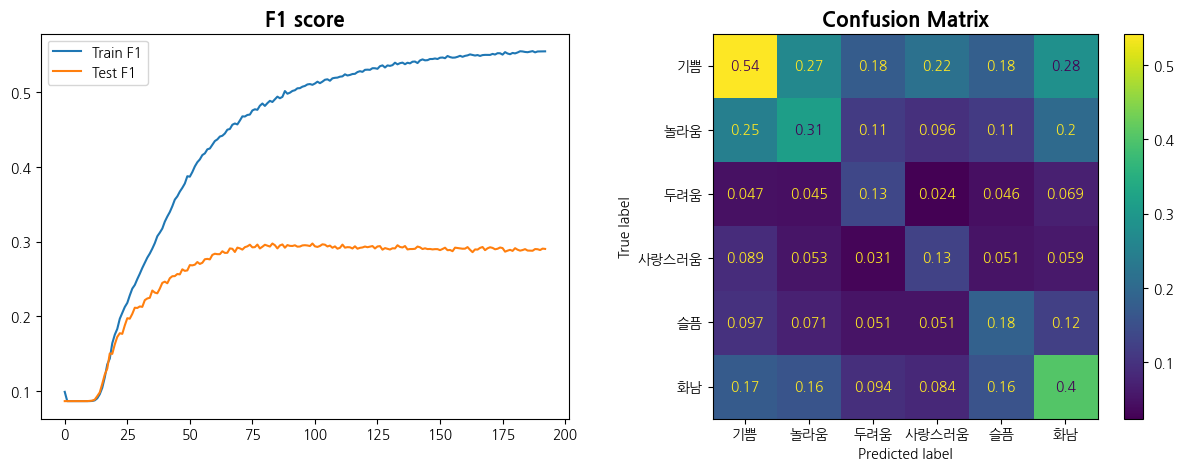

In [32]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
from sklearn.metrics import ConfusionMatrixDisplay

fig, axe = plt.subplots(1, 2, figsize=(15, 5))


titlearg = {
    'fontsize' : 15,
    'fontweight' : 'bold',

}
plt.axes(axe[0])
plt.title('F1 score', **titlearg)
plt.plot(results[0], label='Train F1')
plt.plot(results[1], label='Test F1')
plt.legend()
plt.axes(axe[1])
plt.title('Confusion Matrix', **titlearg)
ConfusionMatrixDisplay(latestcm / latestcm.sum(axis = 1), display_labels=locationnameonly).plot(ax= axe[1])
plt.show()

In [ ]:
# !pip install bareunpy

In [ ]:
location

MultiIndex([(   '기쁨', 0),
            (  '놀라움', 1),
            (   '화남', 5),
            (   '슬픔', 4),
            ('사랑스러움', 3),
            (  '두려움', 2)],
           names=['VerifyEmotionTarget', 0])

In [33]:
stdsentence = '교육을 담당하는 보건의료 대표 교육기관으로 오송에 본원을 비롯해 전국 지역센터 7곳을 운영하며 연간 300만명의 교육을 담당하고 있다.'
dialectsentence = '음성 인식 테스트 해보기 만약 음성이 잘 인식된다면 이 문장이 제대로 나오겠지'

softmax = torch.softmax
std = model(torch.tensor(vocab(tokenizer(stdsentence)), device=DEVICE), torch.tensor([0], device=DEVICE))
dialect = model(torch.tensor(vocab(tokenizer(dialectsentence)), device=DEVICE), torch.tensor([0], device=DEVICE))
# std = softmax(std)
# dialect = softmax(dialect)

stdloc = std.argmax().detach().cpu().numpy()
dialectloc = dialect.argmax().detach().cpu().numpy()
print(softmax(std, dim=1))

print(f"std : {std}, dialect : {dialect}")
print(f"std : {locationnameonly[stdloc]}, dialect : {locationnameonly[dialectloc]}")
# print(f'std : {stdsentence}, dialect : {dialectsentence}')



tensor([[0.3761, 0.1028, 0.0859, 0.0712, 0.0488, 0.3151]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
std : tensor([[ 1.0339, -0.2628, -0.4424, -0.6305, -1.0084,  0.8568]],
       device='cuda:0', grad_fn=<AddmmBackward0>), dialect : tensor([[ 1.3095,  2.2430, -2.4980, -0.4596, -2.4470,  0.0762]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
std : 기쁨, dialect : 놀라움


In [ ]:
location

MultiIndex([(   '기쁨', 0),
            (  '놀라움', 1),
            (   '화남', 5),
            (   '슬픔', 4),
            ('사랑스러움', 3),
            (  '두려움', 2)],
           names=['VerifyEmotionTarget', 0])